In [ ]:
! pip install torchmetrics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 926.4/926.4 kB 14.4 MB/s eta 0:00:00


In [ ]:
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from transformers import RobertaTokenizer, RobertaForSequenceClassification, AdamW, get_scheduler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, classification_report, confusion_matrix

import pandas as pd
import numpy as np
import math

from tabulate import tabulate
import tqdm
import random
from torchmetrics.classification import Recall, Accuracy, AUROC, Precision

### Prepare Data

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
path = '/content/drive/MyDrive/ADL/PAPER/cyberbullying_tweets.csv.zip'

In [ ]:
import zipfile

with zipfile.ZipFile(path, 'r') as zip_ref:
    zip_ref.extractall()
df = pd.read_csv('cyberbullying_tweets.csv')
print(df.head())

                                          tweet_text cyberbullying_type
0  In other words #katandandre, your food was cra...  not_cyberbullying
1  Why is #aussietv so white? #MKR #theblock #ImA...  not_cyberbullying
2  @XochitlSuckkks a classy whore? Or more red ve...  not_cyberbullying
3  @Jason_Gio meh. :P  thanks for the heads up, b...  not_cyberbullying
4  @RudhoeEnglish This is an ISIS account pretend...  not_cyberbullying


In [ ]:
df.info()
df = df.rename(columns={'tweet_text': 'text', 'cyberbullying_type': 'sentiment'})

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47692 entries, 0 to 47691
Data columns (total 2 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   tweet_text          47692 non-null  object
 1   cyberbullying_type  47692 non-null  object
dtypes: object(2)
memory usage: 745.3+ KB


In [ ]:
df.duplicated().sum()

36

In [ ]:
df = df.drop_duplicates()

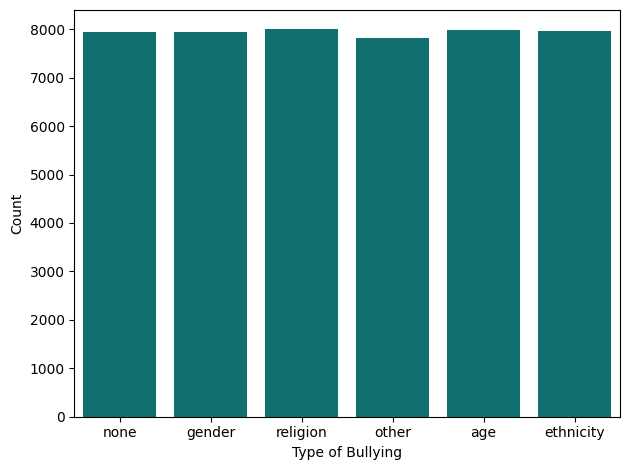

In [ ]:
# plot distribution
import seaborn as sns
import matplotlib.pyplot as plt
sns.color_palette("cubehelix", as_cmap=True)

# change other_cyberbullying to other and not_cyberbullying to none
df['sentiment'] = df['sentiment'].replace(['other_cyberbullying'], 'other')
df['sentiment'] = df['sentiment'].replace(['not_cyberbullying'], 'none')
sns.countplot(x='sentiment', data=df, color='#008080')
# fix labeling
# plt.title('Sentiment Distribution')
plt.xlabel('Type of Bullying')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

In [ ]:
!pip install emoji
import nltk
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('stopwords')
nltk.download('punkt_tab')

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 586.9/586.9 kB 7.2 MB/s eta 0:00:00


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

In [ ]:
import re
import string
import emoji
from nltk.stem import WordNetLemmatizer, PorterStemmer
from nltk.corpus import stopwords

def remove_emojis(text):
    text = emoji.demojize(text)
    text = text.replace(':', ' ')
    text = ' '.join(text.split())
    return text

def remove_urls(text):
    url_pattern = re.compile(r'https?://\S+|www\.\S+')
    return url_pattern.sub(r'', text)

def remove_html(text):
    html_pattern = re.compile('<.*?>')
    return html_pattern.sub(r'', text)

def remove_punctuations(text):
    translator = str.maketrans('', '', string.punctuation)
    return text.translate(translator)

def remove_stopwords(text):
    stop_words = set(stopwords.words('english'))
    word_tokens = nltk.word_tokenize(text)
    filtered_text = [word for word in word_tokens if word.lower() not in stop_words]
    return ' '.join(filtered_text)

def lemmatize_words(text):
    lemmatizer = WordNetLemmatizer()
    word_tokens = nltk.word_tokenize(text)
    return ' '.join([lemmatizer.lemmatize(word) for word in word_tokens])

def stem_words(text):
    stemmer = PorterStemmer()
    word_tokens = nltk.word_tokenize(text)
    return ' '.join([stemmer.stem(word) for word in word_tokens])

def preprocess_text(text):
    text = remove_emojis(text)
    text = remove_urls(text)
    text = remove_html(text)
    text = remove_punctuations(text)
    text = remove_stopwords(text)
    text = lemmatize_words(text)
    text = stem_words(text)
    return text

df['text'] = df['text'].apply(preprocess_text)

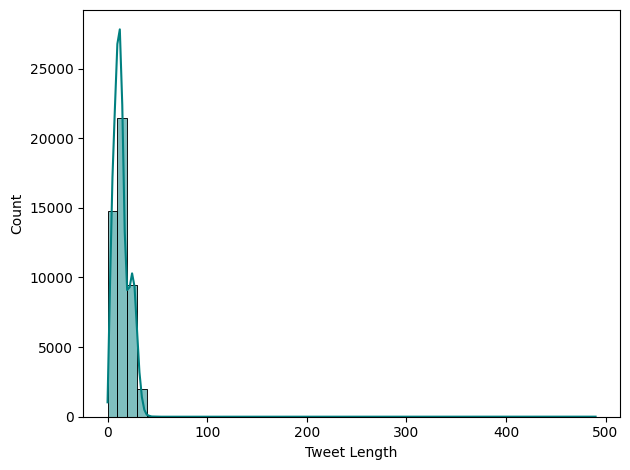

<ipython-input-12-9ef9c9a3e4eb>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop('tweet_length', axis=1, inplace=True)


In [ ]:
# plot tweets by length
df['tweet_length'] = df['text'].apply(lambda x: len(x.split()))
sns.histplot(df['tweet_length'], bins=50, kde=True, color='#008080')
# plt.title('Distribution of Tweet Lengths')
plt.xlabel('Tweet Length')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

# filter out tweets over 50 words
df = df[df['tweet_length'] <= 30]

df.drop('tweet_length', axis=1, inplace=True)


### Tokenization

In [ ]:
tokenizer = RobertaTokenizer.from_pretrained('roberta-base')

token_ids = []
attention_masks = []

def preprocessing(input_text, tokenizer):
    return tokenizer.encode_plus(
        input_text,
        add_special_tokens=True,
        max_length=32,
        pad_to_max_length=True,
        return_attention_mask=True,
        return_tensors='pt'
    )

for text in df.text:
    encoding_dict = preprocessing(text, tokenizer)
    token_ids.append(encoding_dict['input_ids'])
    attention_masks.append(encoding_dict['attention_mask'])

token_ids = torch.cat(token_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2834: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [ ]:
labels = df['sentiment'].map({'none': 0, 'gender': 1, 'religion': 2, 'ethnicity': 3, 'age': 4, 'other': 5}).values
labels = torch.tensor(labels)

In [ ]:
val_ratio = 0.2
batch_size = 16

train_idx, val_idx = train_test_split(
    np.arange(len(df)),
    test_size=val_ratio,
    shuffle=True,
    stratify=labels
)

train_set = TensorDataset(token_ids[train_idx],
                          attention_masks[train_idx],
                          labels[train_idx])

val_set = TensorDataset(token_ids[val_idx],
                        attention_masks[val_idx],
                        labels[val_idx])

train_loader = DataLoader(
    train_set,
    sampler=RandomSampler(train_set),
    batch_size=batch_size
)

val_loader = DataLoader(
    val_set,
    sampler=SequentialSampler(val_set),
    batch_size=batch_size
)

In [ ]:
print('{:>5,} training samples'.format(train_set.__len__()))
print('{:>5,} validation samples'.format(val_set.__len__()))

36,960 training samples
9,241 validation samples


In [ ]:
fine_tune = True
epochs = 3
learning_rate = [2e-5, 3e-5, 5e-5][1]

In [ ]:
model = RobertaForSequenceClassification.from_pretrained(
    'roberta-base',
    num_labels=6,
    output_attentions=False,
    output_hidden_states=False
)

total_parameters = 0

for name, param in model.named_parameters():
    param.requires_grad = False
    if 'classifier' in name:
        param.requires_grad = True
        total_parameters += param.numel()

print(f'Total parameters (no fine tune): {total_parameters}')

if fine_tune:
    for name, param in model.named_parameters():
        param.requires_grad = True
        total_parameters += param.numel()

print(f'Total parameters (fine tune): {total_parameters}')

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Total parameters (no fine tune): 595206
Total parameters (fine tune): 125245452


In [ ]:
import platform

# Pick the system you have and select GPU if you can
if platform.system() == 'Darwin':
    device = torch.device('mps') if torch.backends.mps.is_available() else torch.device('cpu')
elif platform.system() == 'Linux':
    device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
else:
    device = torch.device('cpu')
print(device)

cpu


In [ ]:
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, eps=1e-8)

### Train the model

In [ ]:
_ = model.to(device)

In [ ]:
all_preds = {}
all_labels = {}
all_logits = {}

for _ in tqdm.tqdm(range(epochs)):
    model.train()
    training_loss = 0
    nb_tr_examples, nb_tr_steps = 0, 0

    for step, batch in enumerate(train_loader):
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch
        optimizer.zero_grad()

        train_output = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)
        train_output.loss.backward()

        optimizer.step()

        training_loss += train_output.loss.item()
        nb_tr_examples += b_input_ids.size(0)
        nb_tr_steps += 1

    model.eval()

    val_accuracy = []
    val_precision = []
    val_recall = []
    val_auroc = []
    pred_list = []
    label_list = []
    logit_list = []


    for batch in val_loader:
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch
        with torch.no_grad():
            eval_output = model(b_input_ids, attention_mask=b_input_mask)

        labels = b_labels.cpu()
        logits = eval_output.logits.cpu() # Store logits for AUROC calculation
        preds = torch.argmax(logits, axis=1).flatten()

        pred_list.extend(preds) # Use extend to accumulate predictions
        label_list.extend(labels) # Use extend to accumulate labels
        logit_list.extend(logits) # Use extend to accumulate logits

        val_accuracy.append(Accuracy(task='multiclass', num_classes=6)(preds, labels))
        val_precision.append(Precision(task='multiclass', num_classes=6)(preds, labels))
        val_recall.append(Recall(task='multiclass', num_classes=6)(preds, labels))
        val_auroc.append(AUROC(task='multiclass', num_classes=6)(logits, labels)) # Calculate AUROC here using logits

    all_preds[f'epoch_{_}'] = pred_list
    all_labels[f'epoch_{_}'] = label_list
    all_logits[f'epoch_{_}'] = logit_list

    # Calculate AUROC after accumulating all predictions and labels for the epoch
    val_auroc = AUROC(task='multiclass', num_classes=6)(torch.stack(logit_list), torch.stack(label_list))

    print('\n\t - Train loss: {:.4f}'.format(training_loss / nb_tr_steps))
    print('\t - Validation Accuracy: {:.4f}'.format(torch.mean(torch.tensor(val_accuracy))))
    print('\t - Validation Precision: {:.4f}'.format(torch.mean(torch.tensor(val_precision))))
    print('\t - Validation Recall: {:.4f}'.format(torch.mean(torch.tensor(val_recall))))
    print('\t - Validation AUROC: {:.4f}'.format(val_auroc)) # Print AUROC for the epoch

  0%|          | 0/1 [00:00<?, ?it/s]

In [ ]:
for _ in tqdm.tqdm(range(1)):
    model.train()
    training_loss = 0
    nb_tr_examples, nb_tr_steps = 0, 0

    for step, batch in enumerate(train_loader):
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch
        optimizer.zero_grad()

        train_output = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)
        train_output.loss.backward()

        optimizer.step()

        training_loss += train_output.loss.item()
        nb_tr_examples += b_input_ids.size(0)
        nb_tr_steps += 1

    model.eval()

    val_accuracy = []
    val_precision = []
    val_recall = []
    val_auroc = []
    pred_list = []
    label_list = []
    logit_list = []


    for batch in val_loader:
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch
        with torch.no_grad():
            eval_output = model(b_input_ids, attention_mask=b_input_mask)

        labels = b_labels.cpu()
        logits = eval_output.logits.cpu() # Store logits for AUROC calculation
        preds = torch.argmax(logits, axis=1).flatten()

        pred_list.extend(preds) # Use extend to accumulate predictions
        label_list.extend(labels) # Use extend to accumulate labels
        logit_list.extend(logits) # Use extend to accumulate logits

        val_accuracy.append(Accuracy(task='multiclass', num_classes=6)(preds, labels))
        val_precision.append(Precision(task='multiclass', num_classes=6)(preds, labels))
        val_recall.append(Recall(task='multiclass', num_classes=6)(preds, labels))
        val_auroc.append(AUROC(task='multiclass', num_classes=6)(logits, labels)) # Calculate AUROC here using logits

    all_preds[f'epoch_{_+1}'] = pred_list
    all_labels[f'epoch_{_+1}'] = label_list
    all_logits[f'epoch_{_+1}'] = logit_list

    # Calculate AUROC after accumulating all predictions and labels for the epoch
    val_auroc = AUROC(task='multiclass', num_classes=6)(torch.stack(logit_list), torch.stack(label_list))

    print('\n\t - Train loss: {:.4f}'.format(training_loss / nb_tr_steps))
    print('\t - Validation Accuracy: {:.4f}'.format(torch.mean(torch.tensor(val_accuracy))))
    print('\t - Validation Precision: {:.4f}'.format(torch.mean(torch.tensor(val_precision))))
    print('\t - Validation Recall: {:.4f}'.format(torch.mean(torch.tensor(val_recall))))
    print('\t - Validation AUROC: {:.4f}'.format(val_auroc)) # Print AUROC for the epoch

In [ ]:
epoch_key = 'epoch_1'  # Change this to access a different epoch's results
preds = all_preds[epoch_key]
labels = all_labels[epoch_key]

# Create the confusion matrix
cm = confusion_matrix(labels, preds)

# Plot the confusion matrix
plt.figure(figsize=(5, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='BuGn', cbar=False,
            xticklabels=['none', 'gender', 'religion', 'ethnicity', 'age', 'other'],
            yticklabels=['none', 'gender', 'religion', 'ethnicity', 'age', 'other'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.tight_layout()
plt.show()

In [ ]:
epoch_key = 'epoch_0'  # Change this to access a different epoch's results
preds = all_preds[epoch_key]
labels = all_labels[epoch_key]

# Create the confusion matrix
cm = confusion_matrix(labels, preds)

# Plot the confusion matrix
plt.figure(figsize=(5, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='BuGn', cbar=False,
            xticklabels=['none', 'gender', 'religion', 'ethnicity', 'age', 'other'],
            yticklabels=['none', 'gender', 'religion', 'ethnicity', 'age', 'other'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.tight_layout()
plt.show()

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

classification_report(labels, preds, target_names=['none', 'gender', 'religion', 'ethnicity', 'age', 'other'])